This notebook includes a program to calculate accuracy, decision time, confidence, and the overall prediction of our neurocomputational model. A defined range of noise levels is used, and for each noise level, 336 images are passed through the two-module model, producing results for accuracy, decision time, and confidence.

In [ ]:
#first off import all modules and dependecies from .py files

from snn_module import *
from triangular_DDM_module import *

use_cuda = False

linear_filter_snn_model = Kheradpisheh_SNN()

if use_cuda:
    linear_filter_snn_model.cuda()


linear_filter_snn_model.load_state_dict(torch.load("saved_l3_kheradpisheh_final.net",
                                                map_location=torch.device('cpu'))) #notice I've loaded the model on CPU

linear_filter_snn_model.eval()  #sets the model to be evaluated, not to be trained                          

#no need to repetitively calculate the linear filters which is time-consuming so instead I load them from already saved arrays.
f_dict={}
for i in range(3):
    f_dict[str(i)]=np.load(f"f_dict_{i}.npy")

#create the entire model
model=Visual_3class_DDM(model=linear_filter_snn_model,f_dict=f_dict)


In [8]:
import os
from PIL import Image


noise_levels=np.round(np.arange(0.03,1,0.04),2)

dir_names=np.array(os.listdir(r"final_task_train_noisy\cow"))
mask=np.isin(dir_names,noise_levels.astype(str))
dir_names=dir_names[mask]

dict_folder={0:r"final_task_train_noisy\cow", 
             1:r"final_task_train_noisy\dog",
             2:r"final_task_train_noisy\horse"}

#defining dictionary of all statistical data

class S1Transform:
    def __init__(self, filter, timesteps = 15):
        self.to_tensor = transforms.ToTensor()
        self.filter = filter
        self.temporal_transform = utils.Intensity2Latency(timesteps)
    def __call__(self, image):
        
        image = self.to_tensor(image) * 255
        image.unsqueeze_(0)
        image = self.filter(image)
        image = sf.local_normalization(image, 8)
        temporal_image = self.temporal_transform(image)
        return temporal_image.sign().byte()

kernels = [ utils.DoGKernel(7,1,2),
            utils.DoGKernel(7,2,1),]
filter = utils.Filter(kernels, padding = 0, thresholds = 50)
s1 = S1Transform(filter)  

print("noise levels=",noise_levels)

noise levels= [0.03 0.07 0.11 0.15 0.19 0.23 0.27 0.31 0.35 0.39 0.43 0.47 0.51 0.55
 0.59 0.63 0.67 0.71 0.75 0.79 0.83 0.87 0.91 0.95 0.99]


In [ ]:
#program for plotting psychometry
import os
from PIL import Image
import pickle

threshold=0.3
data_statistics = {"cow":{},"dog":{},"horse":{}}
# Loop through all files in the folder

for key in list(dict_folder.keys()):
    data_statistics[list(data_statistics.keys())[int(key)]]["DecisionTime"]={}
    data_statistics[list(data_statistics.keys())[int(key)]]["Confidence"]={}
    data_statistics[list(data_statistics.keys())[int(key)]]["Prediction"]={}
    data_statistics[list(data_statistics.keys())[int(key)]]["Accuracy"]={}

    for foldername in dir_names:

        data_statistics[list(data_statistics.keys())[int(key)]]["DecisionTime"][foldername]=[]
        data_statistics[list(data_statistics.keys())[int(key)]]["Confidence"][foldername]=[]
        data_statistics[list(data_statistics.keys())[int(key)]]["Prediction"][foldername]=[]
        data_statistics[list(data_statistics.keys())[int(key)]]["Accuracy"][foldername]=[]

        dir_path=os.path.join(dict_folder[key], foldername)
        pred_labels=[]

        for filename in os.listdir(dir_path):

            if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                img_path = os.path.join(dir_path, filename)
                img = Image.open(img_path)
                img=img.convert("L")
                input_spike_wave=s1(img)
                
                pred_class, decision_time, confidence= model.decide_triangle_DDM(input_spike_wave,threshold)

                data_statistics[list(data_statistics.keys())[int(key)]]["DecisionTime"][foldername]+=[decision_time]
                data_statistics[list(data_statistics.keys())[int(key)]]["Confidence"][foldername]+=[confidence]
                data_statistics[list(data_statistics.keys())[int(key)]]["Prediction"][foldername]+=[pred_class]


        data_statistics[list(data_statistics.keys())[int(key)]]["Prediction"][foldername]=np.array(data_statistics[list(data_statistics.keys())[int(key)]]["Prediction"][foldername])
        pred_labels=data_statistics[list(data_statistics.keys())[int(key)]]["Prediction"][foldername].copy()
        acc=np.round(len(pred_labels[pred_labels==int(key)])/len(pred_labels),3)

        data_statistics[list(data_statistics.keys())[int(key)]]["Accuracy"][foldername]+=[acc]
        data_statistics[list(data_statistics.keys())[int(key)]]["Accuracy"][foldername]=np.array(data_statistics[list(data_statistics.keys())[int(key)]]["Accuracy"][foldername])
        data_statistics[list(data_statistics.keys())[int(key)]]["DecisionTime"][foldername]=np.array(data_statistics[list(data_statistics.keys())[int(key)]]["DecisionTime"][foldername])
        data_statistics[list(data_statistics.keys())[int(key)]]["Confidence"][foldername]=np.array(data_statistics[list(data_statistics.keys())[int(key)]]["Confidence"][foldername])

 
    print(list(data_statistics.keys())[int(key)]+" is done")
    with open(f"model_psycho_statistics_th{threshold}_"+list(data_statistics.keys())[int(key)]+"_new.pkl", 'wb') as f:
        pickle.dump(data_statistics, f)


with open(f"model_psycho_statistics_th{threshold}.pkl", 'wb') as f:
        pickle.dump(data_statistics, f)   

print(f"the final data_statistics dictionary is saved as model_psycho_statistics_th{threshold}.pkl")             

cow is done
dog is done
horse is done


In [19]:
import pickle

data_statistics_path=f"model_psycho_statistics_th{threshold}.pkl"
with open(data_statistics_path, 'rb') as f:
        data_statistics=pickle.load(f)

In [10]:
#creating a pooled dictionary

pooled_data={list(data_statistics["cow"].keys())[0]:{}, list(data_statistics["cow"].keys())[1]:{},
             list(data_statistics["cow"].keys())[2]:{},list(data_statistics["cow"].keys())[3]:{}}


for key2 in pooled_data.keys():

    for key3 in data_statistics["cow"][key2].keys():

        pooled_data[key2][key3]=np.hstack([data_statistics[key1][key2][key3] for key1 in data_statistics.keys()])     

In [11]:
threshold=0.3
n=len(pooled_data["DecisionTime"]["0.03"])

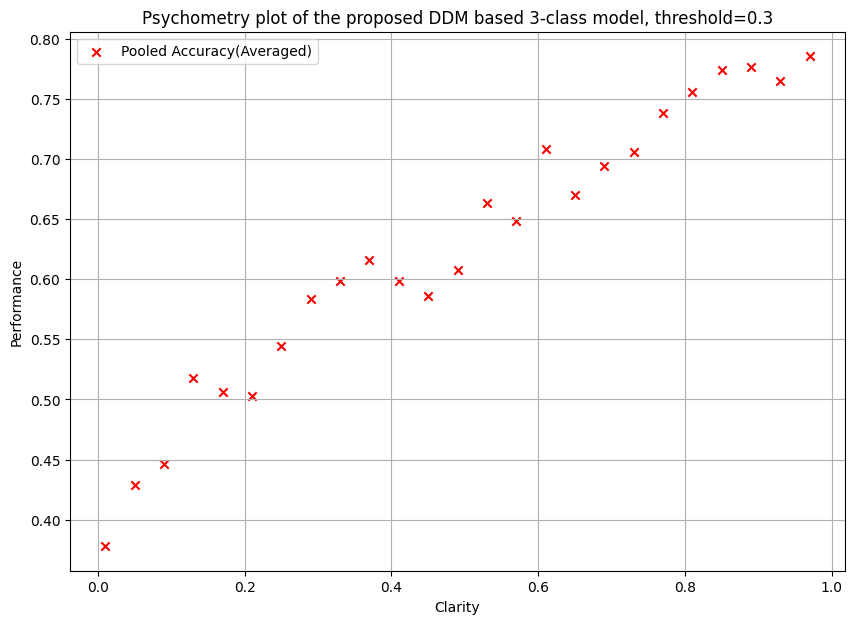

In [12]:
#first off, accuracy vs clarity, plotting pooled data

plt.figure(figsize=(10,7))

# plt.scatter(1-noise_levels[::-1],[pooled_data["Accuracy"][str(key)][0] for key in noise_levels[::-1]],label="cow",color="cyan")
# plt.scatter(1-noise_levels[::-1],[pooled_data["Accuracy"][str(key)][1] for key in noise_levels[::-1]],label="dog",color="orange")
# plt.scatter(1-noise_levels[::-1],[pooled_data["Accuracy"][str(key)][2] for key in noise_levels[::-1]],label="horse",color="green")

plt.scatter(1-noise_levels[::-1],[pooled_data["Accuracy"][str(key)].mean() for key in noise_levels[::-1]],label="Pooled Accuracy(Averaged)",color="red",marker="x")
plt.xlabel("Clarity")
plt.ylabel("Performance")
plt.title(f"Psychometry plot of the proposed DDM based 3-class model, threshold={threshold}")
#plt.xscale("log")
plt.grid()
#plt.yscale("log")
plt.legend()
#plt.savefig("psychometry_plot")
plt.show()

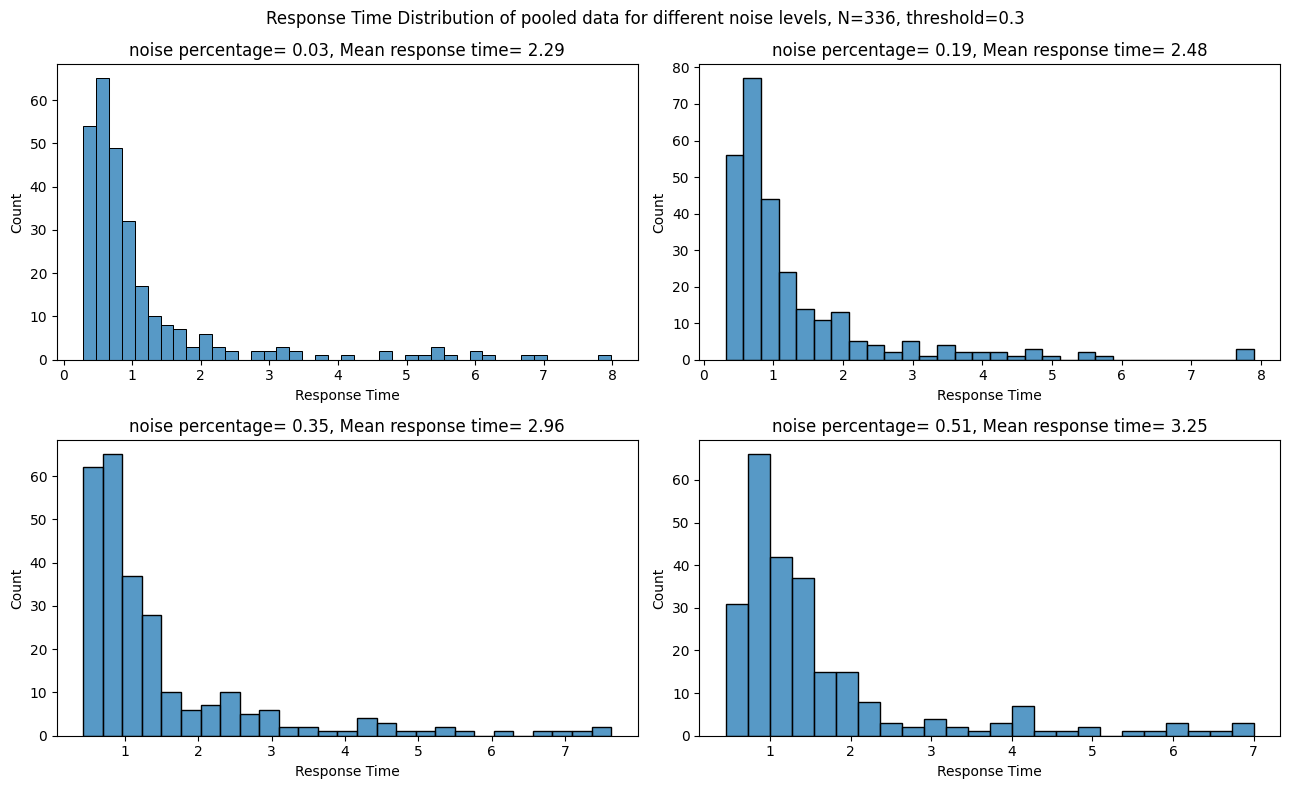

In [13]:
#decision time, vs noise level
import seaborn as sb
#histogram plot

plt.figure(figsize=(13,8))
plt.suptitle(f"Response Time Distribution of pooled data for different noise levels, N={len(pooled_data["DecisionTime"]["0.31"])}, threshold={threshold}")
for i,noise in enumerate(noise_levels[np.arange(0,15,4)]):

    arr=pooled_data["DecisionTime"][str(noise)]
    arr_filt=arr[arr<8]
    plt.subplot(2,2,i+1,title=f"noise percentage= {noise}, Mean response time= {np.round(arr.mean(),2)}")
    sb.histplot(arr_filt)
    plt.xlabel("Response Time")

plt.tight_layout()
#plt.savefig("RT_distribution")
plt.show()


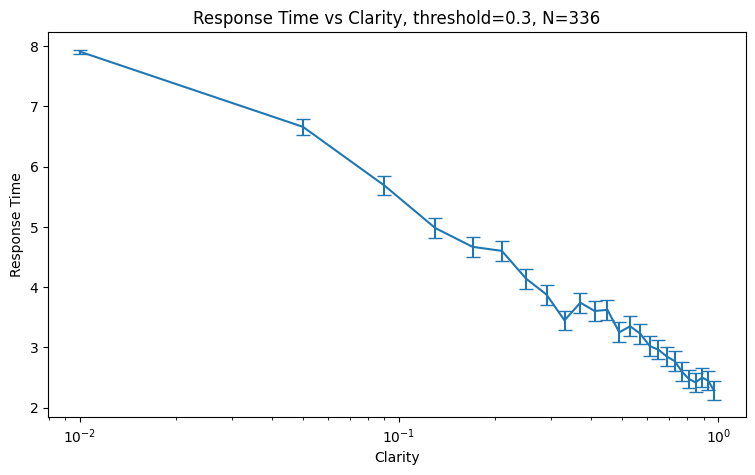

In [14]:
#Pooled RT vs clarity

plt.figure(figsize=(9,5))
arr_rt=np.array([pooled_data["DecisionTime"][key] for key in pooled_data["DecisionTime"].keys()])

plt.errorbar(x=1-noise_levels,y=arr_rt.mean(axis=1),yerr=arr_rt.std(axis=1)/np.sqrt(n-1),capsize=5)
plt.title(f"Response Time vs Clarity, threshold={threshold}, N={n}")
plt.ylabel("Response Time")
plt.xlabel("Clarity")
plt.xscale("log")
#plt.savefig("Pooled_RT_clarity")
#plt.yscale("log")
plt.show()

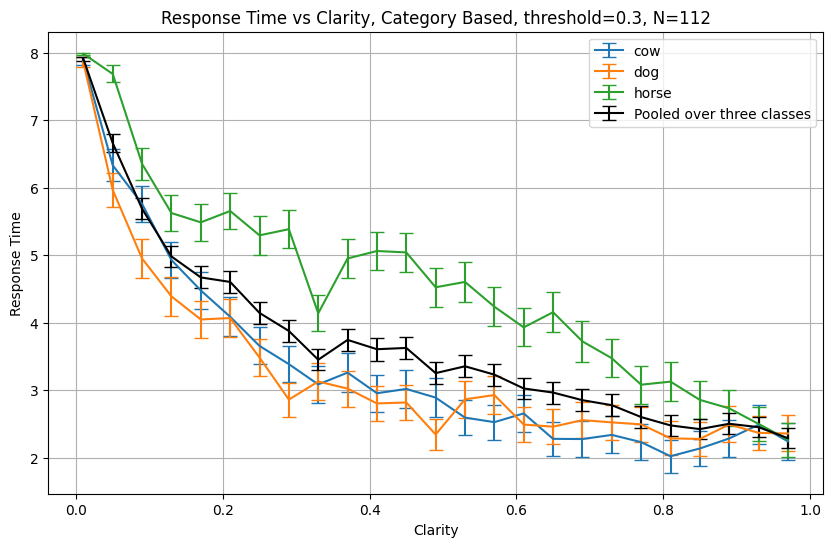

In [15]:
#RT_vs_clarity, category based

plt.figure(figsize=(10,6))

for key in data_statistics.keys():
    arr_rt=np.array([data_statistics[key]["DecisionTime"][key1].mean() for key1 in data_statistics[key]["DecisionTime"].keys()])
    error_arr_rt=np.array([data_statistics[key]["DecisionTime"][key1].std()/np.sqrt(n//3-1) for key1 in data_statistics[key]["DecisionTime"].keys()])

    plt.errorbar(x=1-noise_levels,y=arr_rt,yerr=error_arr_rt,capsize=5,label=key)

arr_rt=np.array([pooled_data["DecisionTime"][key] for key in pooled_data["DecisionTime"].keys()])

plt.errorbar(x=1-noise_levels,y=arr_rt.mean(axis=1),yerr=arr_rt.std(axis=1)/np.sqrt(n-1),capsize=5,label="Pooled over three classes",c="k")
plt.title(f"Response Time vs Clarity, threshold={threshold}, N={n}")
plt.title(f"Response Time vs Clarity, Category Based, threshold={threshold}, N={n//3}")
plt.ylabel("Response Time")
plt.xlabel("Clarity")
#plt.xscale("log")
plt.legend()
plt.grid()
#plt.savefig("category_RT_vs_clarity")
#plt.yscale("log")
plt.show()   

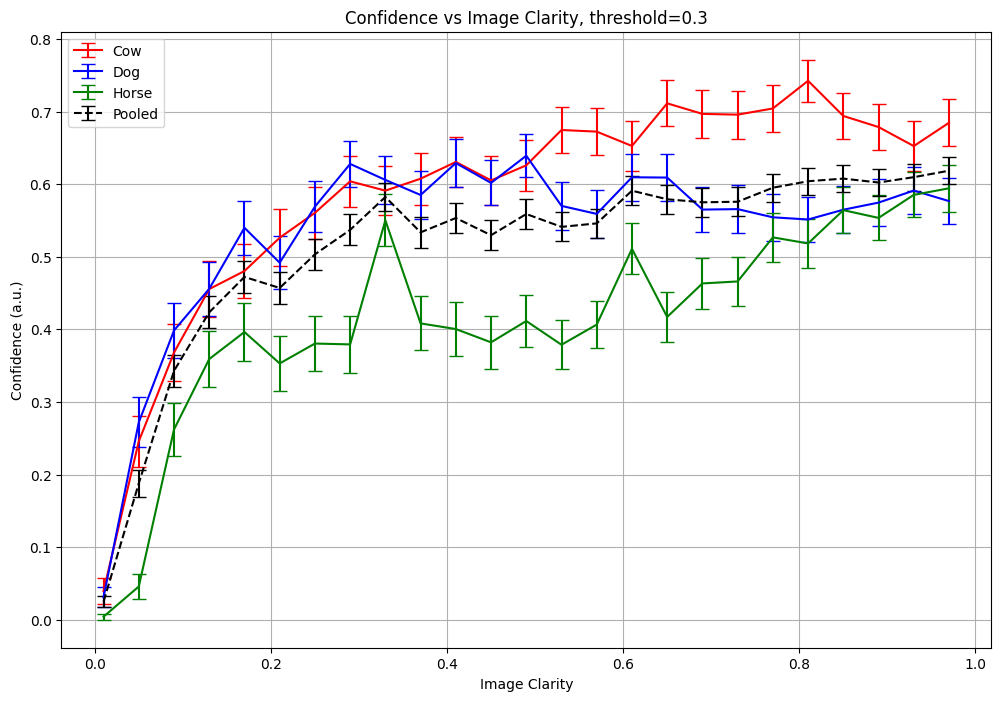

In [16]:
#confidence vs clarity

plt.figure(figsize=(12,8))

plt.errorbar(x=1-noise_levels[::-1], y=[data_statistics["cow"]["Confidence"][str(key)].mean() for key in noise_levels[::-1]], yerr=[data_statistics["cow"]["Confidence"][str(key)].std()/np.sqrt(n//3-1) for key in noise_levels[::-1]],
         color="red",label="Cow",capsize=5)
plt.errorbar(x=1-noise_levels[::-1], y=[data_statistics["dog"]["Confidence"][str(key)].mean() for key in noise_levels[::-1]], yerr=[data_statistics["dog"]["Confidence"][str(key)].std()/np.sqrt(n//3-1) for key in noise_levels[::-1]],
         color="blue",label="Dog",capsize=5)
plt.errorbar(x=1-noise_levels[::-1], y=[data_statistics["horse"]["Confidence"][str(key)].mean() for key in noise_levels[::-1]], yerr=[data_statistics["horse"]["Confidence"][str(key)].std()/np.sqrt(n//3-1) for key in noise_levels[::-1]],
         color="green",label="Horse",capsize=5)


plt.errorbar(x=1-noise_levels[::-1], y=[pooled_data["Confidence"][str(key)].mean() for key in noise_levels[::-1]],
        yerr=[pooled_data["Confidence"][str(key)].std()/np.sqrt(n-1) for key in noise_levels[::-1]],color="black",label="Pooled",ls="--",capsize=5)


plt.xlabel("Image Clarity")

plt.ylabel("Confidence (a.u.)")
plt.title(f"Confidence vs Image Clarity, threshold={threshold}")
plt.legend()
#plt.xscale("log")
#plt.yscale("log")
#plt.savefig("confidence_vs_clarity")
plt.grid()
plt.show()


 ********************************************************************** 

              precision    recall  f1-score   support

         0.0       0.65      0.74      0.69      2800
         1.0       0.59      0.70      0.64      2800
         2.0       0.64      0.43      0.51      2800

    accuracy                           0.62      8400
   macro avg       0.63      0.62      0.62      8400
weighted avg       0.63      0.62      0.62      8400



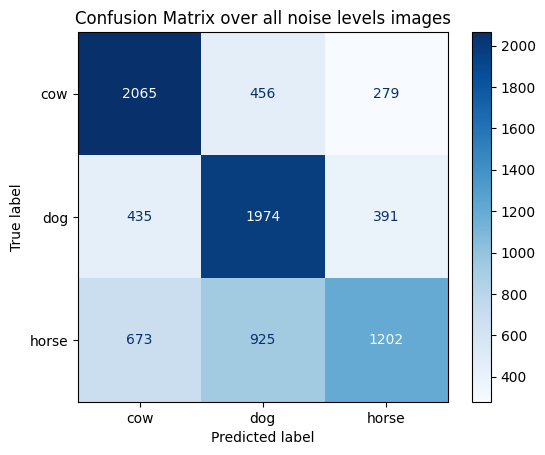

In [ ]:
#confusion matrix and classification report

from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report

pred_labels_all=[]
true_labels_all=[]

for i,c in enumerate(data_statistics.keys()):

    arr=np.hstack([data_statistics[c]["Prediction"][key] for key in data_statistics[c]["Prediction"].keys()])
    pred_labels_all+=[arr]
    true_labels_all+=[i*np.ones(len(arr))]

pred_labels_all=np.array(pred_labels_all)    
true_labels_all=np.array(true_labels_all)

pred_labels_all=pred_labels_all.flatten()
true_labels_all=true_labels_all.flatten()


print("\n",70*"*","\n")
print(classification_report(true_labels_all,pred_labels_all))

cm=confusion_matrix(true_labels_all,pred_labels_all)


cm_display=ConfusionMatrixDisplay(cm,display_labels=["cow","dog","horse"])
cm_display.plot(cmap="Blues")
plt.title("Confusion Matrix over all noise levels images")

plt.show()